# Topic modelling
## r/conspiracy comments containing "vaccine"
**Group members**
* Maheep T
* Sanchi S
***

## Import modules

In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
from dfply import *
import preprocessor as p
import unicodedata
import pickle
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from kwic import keywords_in_context
from operator import itemgetter
from datetime import datetime as dt
from keyness import log_likelihood
# sklearn
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# download
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Read files

In [2]:
base_dir = 'C:\\Users\\Maheep\\Documents\\TUM\\WiSe2020\\CSS\\code\\reddit-anti-vax' #import os; os.getcwd()
data_dir = base_dir + '\\data'

filename = data_dir + "\\" + "comments_vaccine_praw.csv" # comments_vaccine/_praw.csv
df_com = pd.read_csv(filename)
df_com = df_com.rename({'Submission ID': 's_id', 'Comment ID': 'c_id', 'Body': 'text', 'Publish Date': 'date', 'Author': 'user', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "submissions_vaccine.csv"
df_sub = pd.read_csv(filename)
df_sub = df_sub.rename({'Post ID': 's_id', 'Title': 'text', 'Publish Date': 'date', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "reddit_bots.csv"
df_bots = pd.read_csv(filename)
list_bots = df_bots['Name'].tolist() ;

In [ ]:
df_com['date'] =  df_com['date'].apply(lambda x: dt.strptime(x,'%Y-%m-%d %H:%M:%S')) # convert str to datetime

In [3]:
# out_file for temp output
out_file = base_dir + "\\" + "out_file.csv"

## Collect Data

* Use pushshift to query "vaccine" submissions (reddit posts)

In [4]:
print(df_sub.shape[0], " rows in submission data")

2905  rows in submission data


* Use PRAW to collect comments by iterating over all "vaccine" submissions
([praw docs](https://praw.readthedocs.io/en/latest/tutorials/comments.html))
    * pushshift comment data has a lot of missing values ([Gaffney, Matias 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0200162) )

In [5]:
print(df_com.shape[0], "rows in comment data")

77366 rows in comment data


## Clean-up and pre-processing

* Remove comments -
  * where user and text were [deleted]
  * where user is a  bot (list of bots from [Klein et. al. 2019](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0225098) )

In [39]:
df_com_pp = df_com.copy() # copy to pre-process dataframe
df_com_pp = df_com_pp >> mask(~((X.user == '[deleted]') & (X.text == '[deleted]'))) # >> summarize(count=n(X.c_id))
df_com_pp = df_com_pp[~df_com_pp['user'].isin(list_bots)]

In [40]:
# test, remove later
df_com_pp['text_og'] = df_com_pp['text']

* Clean - removes URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys ([Source](https://pypi.org/project/tweet-preprocessor/))

In [41]:
def func_clean(text):
    text = unicodedata.normalize("NFKC", text)  # remove unicode chars like emojis and breaks
    #text = re.sub(r'[^\x00-\x7F]+', " ", text)
    text = re.sub(r'[\r|\n|\r\n]+', " ", text) # remove extra newlines
    text = re.sub(r'[(){}[\]><]+', "", text) # remove brackets 
    text = re.sub(r'\/?u\/[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]', "", text) # remove user names
    text = p.clean(text) # from preprocessor lib
    return text
    
df_com_pp['text'] = df_com_pp['text'].apply(func_clean)

* Expanding contractions ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [42]:
from contractions import CONTRACTION_MAP
import re

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

df_com_pp['text'] = df_com_pp['text'].apply(expand_contractions)

* Tokenise <= lowercase + remove punctuation ([Source](https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e))

In [43]:
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.lower()) # lowercase
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))) # remove punctuation

tt = TweetTokenizer() # does better than default word_tokenizer
df_com_pp['text'] = df_com_pp['text'].apply(tt.tokenize) 

* Fix repetition in words e.g. "Coooolll!" => "Cool!" ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [44]:
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

df_com_pp['text'] = df_com_pp['text'].apply(remove_repeated_characters)

* Remove tokens that are integers

In [45]:
def func_filter_int(l):
    new_l = list()
    for tkn in l:
        tkn = re.sub(r'[-+*/$%.,]+', '', tkn)
        if not tkn.isnumeric() : new_l.append(tkn)
    return new_l

df_com_pp['text'] = df_com_pp['text'].apply(func_filter_int)

* Remove stopwords

In [46]:
stop_words = stopwords.words('english')
def func_filter_stopwords(l):
    return list([w for w in l if not w in stop_words])
df_com_pp['text'] = df_com_pp['text'].apply(func_filter_stopwords)

* ~~Stemming (not lemmatising as it needs the whole sentence context to be effective)~~

In [47]:
# ps = PorterStemmer()
# df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [ps.stem(word) for word in x])


* Lemmatizing (preferred over a stemmer because it produces more readable words. Output that is easy to read is very desirable in topic modelling.) ([Source](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py))

In [48]:
lemmatizer = WordNetLemmatizer()
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

* save/load data because it takes long to do preprocessing

In [94]:
filename = data_dir + "\\" + "df_com_pp.dat"
# pickle.dump(df_com_pp, open(filename, 'wb')) # SAVE
# df_com_pp = pickle.load(open(filename, 'rb')) # LOAD

## Explore the data

* Weekly comment frequency on "vaccine" posts

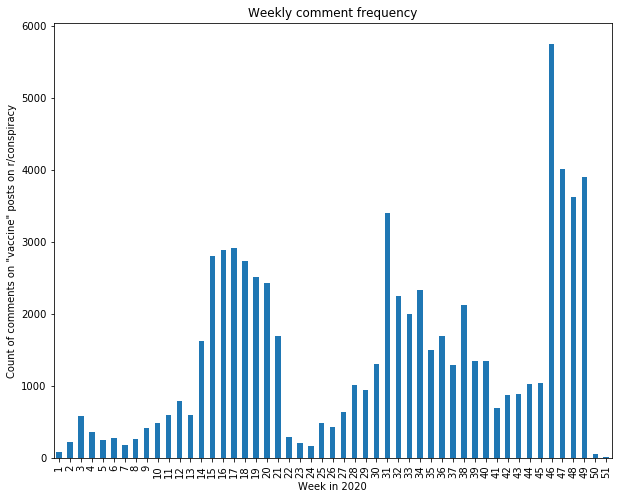

In [217]:
df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week
df_new = df_com_pp.groupby('week').size()

fig = plt.figure(figsize=[10,8])
ax = plt.subplot()
ax = df_new.plot.bar()
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of comments on "vaccine" posts on r/conspiracy')
ax.set_title('Weekly comment frequency')
# #plt.grid()
plt.show()
# plt.cla()
# plt.clf()
# plt.close()
df_com_total = df_new.copy()

* Weekly comment frequency of comments mentioning "bill gate"

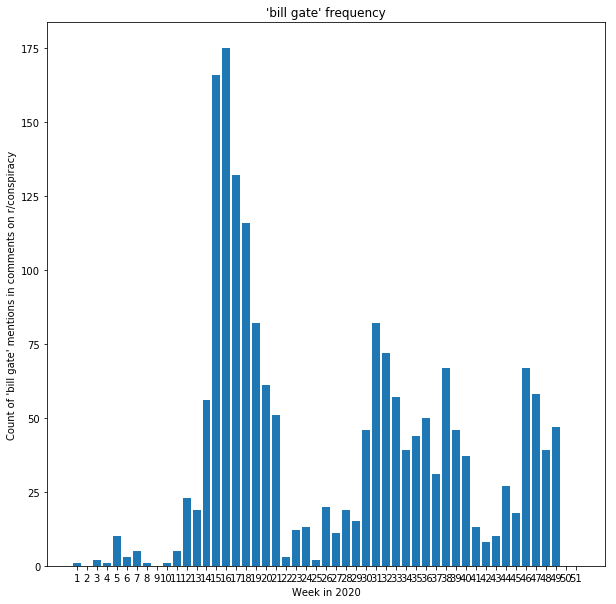

In [50]:
def func_gates(x):
    return True if (('bill' in x) & ('gate' in x)) else False
df_com_pp['gates'] = df_com_pp['text'].apply(lambda x: func_gates(x))
df_com_pp >> filter_by(X.gates == True)
df_new = df_com_pp.groupby('week').agg({'gates' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['gates'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'bill gate\' mentions in comments on r/conspiracy')
ax.set_title('\'bill gate\' frequency')
# #plt.grid()
plt.show()

* Weekly comment frequency of comments mentioning "side effect"

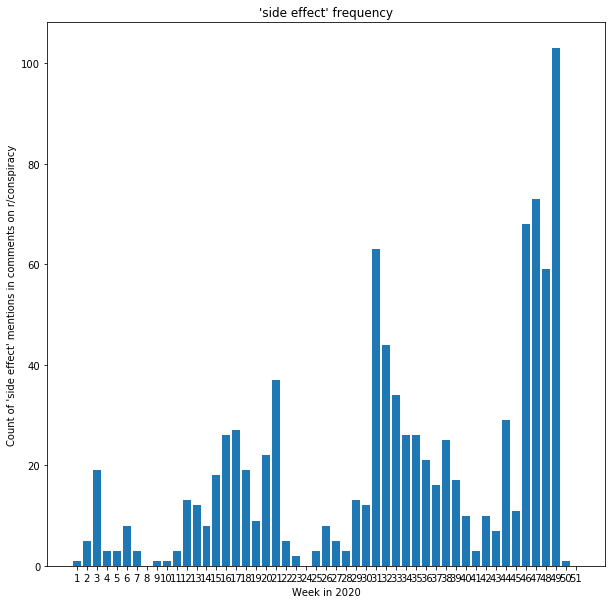

In [51]:
def func_effect(x):
    return True if (('side' in x) & ('effect' in x)) else False
df_com_pp['effect'] = df_com_pp['text'].apply(lambda x: func_effect(x))
df_new = df_com_pp.groupby('week').agg({'effect' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['effect'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'side effect\' mentions in comments on r/conspiracy')
ax.set_title('\'side effect\' frequency')
# #plt.grid()
plt.show()

* Most important words/phrases ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06a%20-%20Text%20Keyphrase%20Extraction.ipynb))

In [52]:
def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:] 
                     for index in range(n)))
    )

def get_top_ngrams(tokens, ngram_val=1, limit=5):

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams
list_tokens_flattened = [token for text in df_com_pp['text'].tolist() for token in text]
#get_top_ngrams(list_tokens_flattened,2,10)

In [53]:
get_top_ngrams(list_tokens_flattened,2,10)

[('bill gate', 1975),
 ('side effect', 1133),
 ('immune system', 988),
 ('covid vaccine', 860),
 ('flu shot', 814),
 ('flu vaccine', 778),
 ('long term', 757),
 ('take vaccine', 744),
 ('get vaccine', 740),
 ('big pharma', 619)]

In [54]:
get_top_ngrams(list_tokens_flattened,1,30)

[('vaccine', 28849),
 ('people', 16276),
 ('would', 10293),
 ('like', 9893),
 ('get', 9304),
 ('one', 8748),
 ('know', 7210),
 ('virus', 6801),
 ('think', 6459),
 ('even', 5824),
 ('u', 5808),
 ('covid', 5704),
 ('make', 5669),
 ('year', 5513),
 ('take', 5181),
 ('time', 5030),
 ('say', 4851),
 ('also', 4735),
 ('want', 4700),
 ('thing', 4666),
 ('right', 4322),
 ('go', 4056),
 ('dont', 4039),
 ('flu', 4000),
 ('work', 3943),
 ('see', 3921),
 ('need', 3850),
 ('going', 3827),
 ('good', 3806),
 ('way', 3795)]

* DFM ([Source](https://blog.koheiw.net/?p=468))

In [55]:
from gensim import corpora, models

print("Serialize tokens")
dic = corpora.Dictionary(df_com_pp['text'].tolist())

print("Construct a document-feature matrix")
mx = [dic.doc2bow(tok) for tok in df_com_pp['text'].tolist()]

print(dic)

Serialize tokens
Construct a document-feature matrix
Dictionary(36501 unique tokens: ['admit', 'anti', 'big', 'billion', 'campaign']...)


* Keyness (Sources [1](http://www.thegrammarlab.com/?p=193) [2](http://ucrel.lancs.ac.uk/llwizard.html))
  * The log_likelihood() function will return a rank ordered list with the following data in each item: - the item - its log likelihood value - its frequency in the corpus - its frequency in the reference corpus ([Source](https://github.com/mikesuhan/keyness))
  * ct.keyness() gives only effect sizes are reported (p values are arguably not particularly useful for keyness analyses). Keyness calculation options include "log-ratio", "%diff", and "odds-ratio". ([Source](https://github.com/kristopherkyle/corpus_toolkit))

In [56]:
#cutoff_date = dt(2020,10,1,0,0,0)
#cutoff_date = dt(2020,7,27,0,0,0) #Pfizer and BionTech start trials
cutoff_date = dt(2020,12,2,0,0,0) #Pfizer and BionTech start trials

df_temp = df_com_pp >> filter_by(X.date > cutoff_date)
corpus = df_temp['text'].tolist()

df_temp = df_com_pp >> filter_by(~(X.date > cutoff_date))
reference_corpus = df_temp['text'].tolist()

In [57]:
print("Cutoff date is ", cutoff_date)
log_likelihood(corpus, reference_corpus)

Cutoff date is  2020-12-02 00:00:00


[('wodarg', 199.876, 29, 0),
 ('yeadon', 197.997, 30, 1),
 ('spike', 187.159, 64, 154),
 ('message', 177.045, 69, 210),
 ('syncytin', 172.307, 25, 0),
 ('mrna', 168.157, 107, 628),
 ('protein', 158.991, 96, 532),
 ('ema', 146.772, 24, 3),
 ('hesitancy', 118.497, 25, 16),
 ('placenta', 107.03, 18, 3),
 ('gate', 94.687, 32, 3758),
 ('infertility', 94.381, 28, 50),
 ('trump', 91.955, 24, 3246),
 ('petition', 83.976, 25, 45),
 ('dr', 75.112, 77, 692),
 ('formation', 66.286, 14, 9),
 ('bot', 66.132, 42, 246),
 ('162b', 62.03, 9, 0),
 ('wolfgang', 62.03, 9, 0),
 ('eudract', 62.03, 9, 0),
 ('bill', 60.461, 25, 2648),
 ('flint', 60.181, 12, 6),
 ('pfizer', 58.768, 56, 476),
 ('polio', 56.193, 20, 2286),
 ('effect', 55.987, 145, 2167),
 ('duration', 54.446, 17, 34),
 ('biontech', 52.735, 14, 19),
 ('bnt', 51.729, 9, 2),
 ('worker', 51.11, 43, 330),
 ('dna', 50.801, 85, 1039),
 ('covid', 49.968, 283, 5421),
 ('unspecified', 48.729, 9, 3),
 ('manual', 47.724, 12, 14),
 ('eu', 46.722, 19, 62),
 ('

In [58]:
# from corpus_toolkit import corpus_tools as ct

# #First, generate frequency lists for each corpus
# corp1freq = ct.frequency(reference_corpus)
# corp2freq = ct.frequency(corpus)

# #then calculate Keyness
# corp_key = ct.keyness(corp1freq, corp2freq, effect = "log-ratio")
# ct.head(corp_key, hits = 10) #to display top hits

In [59]:
# corp1freq['bihar']

In [60]:
# df_temp = df_com >> filter_by(X.date > cutoff_date)
# df_temp['text'] = df_temp['text'].str.lower()
# KEYWORDS = ['bihar']
# for i in range(0,df_temp.shape[0]):
#     TEXT = df_temp[i,2]
#     keywords_in_context(TEXT, KEYWORDS)

---
## Explore data - New stuff

In [61]:
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents(df_com_pp['text'].tolist())
finder

* Key nouns ???

In [62]:
bigram_measures = BigramAssocMeasures()                                                
finder.nbest(bigram_measures.raw_freq, 10)

[('bill', 'gate'),
 ('side', 'effect'),
 ('immune', 'system'),
 ('covid', 'vaccine'),
 ('flu', 'shot'),
 ('flu', 'vaccine'),
 ('long', 'term'),
 ('take', 'vaccine'),
 ('get', 'vaccine'),
 ('big', 'pharma')]

In [63]:
finder.nbest(bigram_measures.pmi, 20)

[('2020comentcomit', 'exebulshitcoment'),
 ('45f', '8c4'),
 ('4g', 'mol'),
 ('6pm', 'uzghu'),
 ('7h15', 'v43c1n35'),
 ('a72', 'loc'),
 ('abdulah', 'petrosaudi'),
 ('abey', 'chutiye'),
 ('abode', 'dexotique'),
 ('abu', 'ghraib'),
 ('acht', 'todesfle'),
 ('ack', 'eter'),
 ('acountmay', '2020comentcomit'),
 ('adenosine', 'triphosphate'),
 ('adis', 'ababa'),
 ('admonished', 'derided'),
 ('adventist', 'unitarian'),
 ('afrocentric', 'metaphysics'),
 ('ahed', 'tyme'),
 ('alba', 'pharmacal')]

In [64]:
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents(df_com_pp['text'].tolist())

In [65]:
trigram_measures = TrigramAssocMeasures()                                                
finder.nbest(trigram_measures.raw_freq, 10)

[('long', 'term', 'effect'),
 ('get', 'flu', 'shot'),
 ('bill', 'melinda', 'gate'),
 ('melinda', 'gate', 'foundation'),
 ('world', 'health', 'organization'),
 ('vaccine', 'cause', 'autism'),
 ('new', 'world', 'order'),
 ('term', 'side', 'effect'),
 ('long', 'term', 'side'),
 ('operation', 'warp', 'speed')]

In [66]:
finder.nbest(trigram_measures.pmi, 10)

[('7h15', 'v43c1n35', 'r3t4rd3d'),
 ('acht', 'todesfle', 'aufgrund'),
 ('acountmay', '2020comentcomit', 'exebulshitcoment'),
 ('adventist', 'unitarian', 'universalist'),
 ('alonal', 'alurate', 'antihistamine'),
 ('alors', 'pardonez', 'moi'),
 ('alurate', 'antihistamine', 'cal'),
 ('am3', '7h15', 'v43c1n35'),
 ('arinjay', 'banerje', 'postdoctoral'),
 ('astringosol', 'campho', 'phenique')]

---
## Non-negative Matrix Factorisation

Topic Models with Non-Negative Matrix Factorization (NMF)

([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06c%20-%20Topic%20Modeling%20with%20scikit-learn.ipynb)) - Sarkar, Text Analytics in Python

Alternate - NMF using sklearn ([Source](https://gist.github.com/ravishchawla/3f346318b85fa07196b761443b123bba))

We find bigrams in the documents. Bigrams are sets of two adjacent words. Using bigrams we can get phrases like “machine_learning” in our output (spaces are replaced with underscores); without bigrams we would only get “machine” and “learning”.

Note that in the code below, we find bigrams and then add them to the original data, because we would like to keep the words “machine” and “learning” as well as the bigram “machine_learning”.

In [ ]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(df_com_pp['text'].tolist(), min_count=20)
for idx in range(len(df_com_pp['text'].tolist())):
    for token in bigram[df_com_pp['text'].tolist()[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            #docs[idx].append(token)
            df_com_pp.iloc[idx, df_temp.columns.get_loc('text')].append(token)

* ~~Remove rare words and common words based on their document frequency ~~

~~Remove words that appear in less than 20 documents or in more than 50% of the documents.~~

In [ ]:
# # Remove rare and common tokens.
# from gensim.corpora import Dictionary

# # Create a dictionary representation of the documents.
# dictionary = Dictionary(df_com_pp['text'].tolist())

# # Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)

---

In [333]:
cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2),
                     token_pattern=None, tokenizer=lambda doc: doc,
                     preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(df_com_pp['text']) #Learn the vocabulary dictionary (fit) and return document-term matrix (transform)
cv_features.shape
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 11422


* tf-Idf transformation

In [334]:
# transformer = TfidfTransformer(smooth_idf=False);
# cv_features = transformer.fit_transform(cv_features);

# from sklearn.preprocessing import normalize;
# cv_features = normalize(cv_features, norm='l1', axis=1)

In [567]:
%%time

nmf_model = NMF(n_components=num_topics, solver='cd', max_iter=2000,
                random_state=42, alpha=.1, l1_ratio=.85)
document_topics = nmf_model.fit_transform(cv_features)

C:\Users\Maheep\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Wall time: 1min 42s


In [574]:
top_terms=20
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, num_topics+1)])
topics_df

,Terms per Topic
Topic1,"vaccine, child, side_effect, polio, vaccine_injury, autism, injury, get, effect, take, flu, covid, safe, covid vaccine, vaccination, risk, case, study, disease, health"
Topic2,"people, would, like, get, one, know, think, u, even, make, thing, want, say, time, right, take, covid, dont, go, year"
Topic3,"npafp_rate, npafp, rate, polio, npafp rate, year, pulse_polio, case_npafp, round, pulse polio, pulse, number, state, child, case, found, five_year, correlation, p, previous_year"
Topic4,"bill_gate, gate, bill, bill_gate bill_gate, bill gate, gate_foundation, world, foundation, u, china, bill_melinda, gate foundation, health, conspiracy_theory, health_organization, epstein, bill_me..."
Topic5,"rockefeller, drug, rockefeller_foundation, john_hopkins, united_state, medical, foundation, drug_trust, rockefeller foundation, medicine, trust, world, state, drug_story, call_tune, china, john, d..."
Topic6,"body, activity, may, sensor, user, human, wave, brain, human_body, example, quantum_dot, flow, data, blood, e_g, system, device, movement, one, task"
Topic7,"vaccine, adverse_reaction, control_group, trial, clinical_trial, drug, hepatitis_b, adverse, licensed, day, one, fda, inert_placebo, control, group, safety, placebo, study, reaction, united_state"
Topic8,"hpv_vaccine, hpv, cervical_cancer, vaccine, hpv vaccine, cancer, long_term, clinical_trial, cervical, vaccination, cervical cancer, safety, trial, study, year_old, efficacy, hpv_vaccine hpv_vaccin..."
Topic9,"virus, immune_system, immune, cell, sars_cov, system, immune system, covid, disease, sars, dna, immune_system immune_system, human, coronavirus, test, new, infection, also, flu, protein"
Topic10,"million, drug, pay_million, pay, merck, settle, case, flu, u, billion, flu_shot, kickback, company, pharmaceutical_company, pfizer, fraud, pay million, pay_billion, lawsuit, pharmaceutical_industry"


* Viewing topic dominance per document using the document-topic matrix

In [569]:
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, num_topics+1)])
dt_df.head(5)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.112,0.000,0.000,0.000,0.005,0.014,0.000,0.000,0.000,0.028
1,0.030,0.016,0.000,0.002,0.024,0.004,0.000,0.000,0.000,0.028
2,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000
4,0.027,0.000,0.000,0.000,0.000,0.018,0.000,0.000,0.011,0.000


* determine the most relevant comment for each topic based on the topic dominance scores 

In [570]:
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                       for t in dominant_topics]
documents = [df_com.iloc[i, df_com.columns.get_loc('text')] for i in document_numbers]

results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                          'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'], 
                          'Paper Name': documents})
results_df

,Dominant Topic,Max Score,Paper Num,Topic,Paper Name
Topic1,T1,1.10608,5061,"vaccine, child, side_effect, polio, vaccine_injury, autism, injury, get, effect, take, flu, covid, safe, covid vaccine, vaccination, risk, case, study, disease, health","What I think is:\n(Regarding initial discussion with other user)\nIf you are just trying to bring a potential danger to light, I agree with you. If you are trying to say all vaccines will do this,..."
Topic2,T2,0.60757,6092,"people, would, like, get, one, know, think, u, even, make, thing, want, say, time, right, take, covid, dont, go, year",Don’t get the vaccine.
Topic3,T3,3.49776,12032,"npafp_rate, npafp, rate, polio, npafp rate, year, pulse_polio, case_npafp, round, pulse polio, pulse, number, state, child, case, found, five_year, correlation, p, previous_year","Weird analogy since the majority of people will need to call a plumber more than once in their life. If you want to use that analogy though, consider that there are instead 131 identified pipes, a..."
Topic4,T4,1.19678,3840,"bill_gate, gate, bill, bill_gate bill_gate, bill gate, gate_foundation, world, foundation, u, china, bill_melinda, gate foundation, health, conspiracy_theory, health_organization, epstein, bill_me...",That's something to think about. It's far enough in the future that I'm sure there might be ways to get out of it but idk. I feel like people who don't get this vaccine will have a huge target ove...
Topic5,T5,3.61466,26596,"rockefeller, drug, rockefeller_foundation, john_hopkins, united_state, medical, foundation, drug_trust, rockefeller foundation, medicine, trust, world, state, drug_story, call_tune, china, john, d...",Mercury in any form I don't want in my body
Topic6,T6,4.00991,18227,"body, activity, may, sensor, user, human, wave, brain, human_body, example, quantum_dot, flow, data, blood, e_g, system, device, movement, one, task",Do you have proof its safe. I like to see an opposite opinion with as many references.
Topic7,T7,3.36726,35069,"vaccine, adverse_reaction, control_group, trial, clinical_trial, drug, hepatitis_b, adverse, licensed, day, one, fda, inert_placebo, control, group, safety, placebo, study, reaction, united_state","I'm not going to quote the press releases for you. If you don't believe me, read them yourself."
Topic8,T8,6.00537,1793,"hpv_vaccine, hpv, cervical_cancer, vaccine, hpv vaccine, cancer, long_term, clinical_trial, cervical, vaccination, cervical cancer, safety, trial, study, year_old, efficacy, hpv_vaccine hpv_vaccin...",Good thing this attitude isn't widespread or we'd be fucked as a society.
Topic9,T9,1.91031,51784,"virus, immune_system, immune, cell, sars_cov, system, immune system, covid, disease, sars, dna, immune_system immune_system, human, coronavirus, test, new, infection, also, flu, protein",SS:\n\nThe United Nations has been forced to admit that a major international vaccine initiative is actually causing the outbreak of the very disease it was supposed to wipe-out.\n\nWhile internat...
Topic10,T10,3.94644,30052,"million, drug, pay_million, pay, merck, settle, case, flu, u, billion, flu_shot, kickback, company, pharmaceutical_company, pfizer, fraud, pay million, pay_billion, lawsuit, pharmaceutical_industry","He claims it’s the Mark of Beast, like the gates conspiracy. However I wonder if he with his stature and money, if he knows something.."


In [571]:
df_com_pp['topic'] = dt_df.idxmax(axis=1)

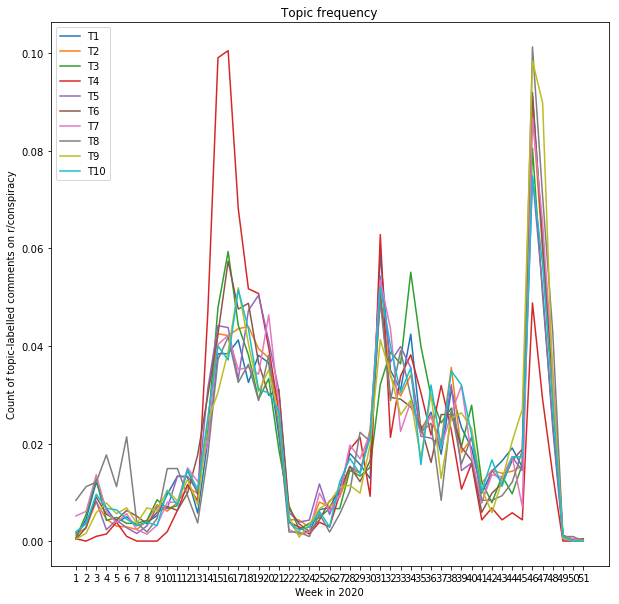

In [572]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# # normalise by dividing each row by total coms that week
# for i in df_com_total.index:
#     df_new.loc[i] = df_new.loc[i]/df_com_total.loc[i]

# normalise by dividing each column by total coms of that topic
#df_new = df_new.divide(df_new.sum(axis=0), axis = 'columns')

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.plot(df_new.index,df_new)
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of topic-labelled comments on r/conspiracy')
ax.set_title('Topic frequency')
ax.legend(df_new.columns, loc='upper left')
# #plt.grid()
plt.show()


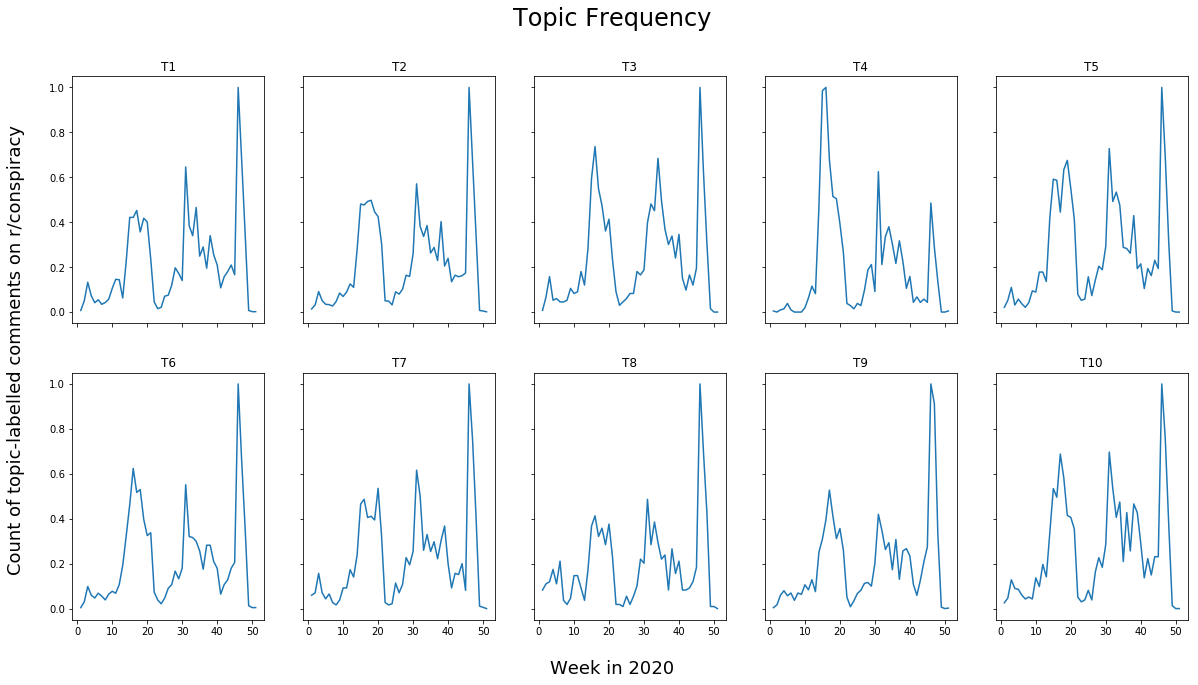

In [573]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# normalise by dividing each column by max/total weekly count of comments with that topic
df_new = df_new.divide(df_new.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(2,5, sharex='col', sharey='row')
fig.set_size_inches([20,10])
idx = 0
for i in range(2):
    for j in range(5):
        ax[i, j].plot(df_new.index,df_new.iloc[:,idx])
        ax[i, j].set_title(df_new.columns[idx])
        idx+=1
fig.text(0.5, 0.95, 'Topic Frequency', ha='center', fontsize=24)
fig.text(0.5, 0.05, 'Week in 2020', ha='center', fontsize=18)
fig.text(0.08, 0.5, 'Count of topic-labelled comments on r/conspiracy', va='center', rotation='vertical', fontsize=18)
plt.show()


---
## Optimise num_topics ( Non-negative Matrix Factorisation )

In [590]:
# Fucntion to find the best number of topics using coherence score. 
def test_NMFs(lower_topics = 4, upper_topics = 16, step_size = 2):
    num_models = (upper_topics - lower_topics) / step_size
    # Iterate through topic numbers to find an optimal number of topics
    mean_sim_scores = []
    models = {}
    count = 1
    for i in range(lower_topics, upper_topics, step_size): 
        print('Testing model', count, 'of', num_models)
        count += 1
#         nmf_model = NMF(n_components=i, solver='cd', max_iter=500,
#                         random_state=42, alpha=.1, l1_ratio=.85)
        nmf_model = NMF(n_components=i, init='nndsvd', max_iter=2000)
        nmf_model.fit_transform(cv_features)
        topic_terms_matrix = nmf_model.components_
        sim_matrix = cosine_similarity(topic_terms_matrix)
        mean_sim_scores.append(np.mean(sim_matrix))
        models[str(i)] = nmf_model

    # Plot the relationship between number of topics and the coherence score
    x = [i for i in range(lower_topics, upper_topics, step_size)]
    plt.figure(figsize=(16,9))
    plt.scatter(x, mean_sim_scores, marker='^', color='blue', label='Mean cosine similarity')
    plt.plot(x, [1/i for i in x], 'g',label=(r'$1/x$'))
    plt.scatter(x, [sim - 1/i for (sim,i) in zip(mean_sim_scores,x)], marker='o', color='red', label='Mean cs - 1/x')
    plt.xlabel('Number of Topics')
    plt.ylabel('Mean Pairwise Cosine Similarity Score')
    plt.axvline(x=30, c='black', ls='--')
    plt.legend()
    plt.show()
    
    return models, mean_sim_scores

Testing model 1 of 26.0
Testing model 2 of 26.0
Testing model 3 of 26.0
Testing model 4 of 26.0
Testing model 5 of 26.0
Testing model 6 of 26.0
Testing model 7 of 26.0
Testing model 8 of 26.0
Testing model 9 of 26.0
Testing model 10 of 26.0
Testing model 11 of 26.0
Testing model 12 of 26.0
Testing model 13 of 26.0
Testing model 14 of 26.0
Testing model 15 of 26.0
Testing model 16 of 26.0
Testing model 17 of 26.0
Testing model 18 of 26.0
Testing model 19 of 26.0
Testing model 20 of 26.0
Testing model 21 of 26.0
Testing model 22 of 26.0
Testing model 23 of 26.0
Testing model 24 of 26.0
Testing model 25 of 26.0
Testing model 26 of 26.0


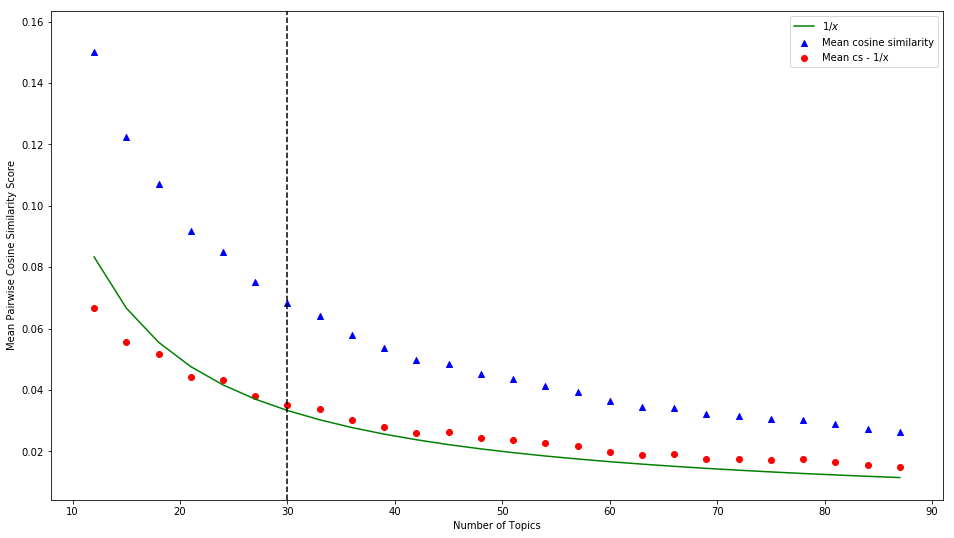

In [592]:
model_objs_NMF, sim_scores = test_NMFs(lower_topics = 12, upper_topics = 90, step_size = 3)

In [687]:
# choose 42, 45 or 48
model_nmf = model_objs_NMF['42']

---
## k-means clustering 

([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

In [691]:
from scipy.spatial.distance import cdist, pdist
import seaborn as sns

In [692]:
document_topics = model_nmf.fit_transform(cv_features)

k_means_fit = KMeans(n_clusters=3,max_iter=300) 
k_means_fit.fit(document_topics)

KMeans(n_clusters=3)

In [693]:
print ("\nSilhouette-score: %0.3f" % silhouette_score(document_topics, k_means_fit.labels_, metric='euclidean'))


Silhouette-score: 0.656


* Silhouette scores plot


([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

In [711]:
silh_scores = []
k_range = range(2,27,1)
for k in k_range: 
    k_means_fitk = KMeans(n_clusters=k,max_iter=300) 
    k_means_fitk.fit(document_topics)
    ss = silhouette_score(document_topics, k_means_fitk.labels_, metric='euclidean')
    silh_scores.append(ss)
    print ("For K value",k,",Silhouette-score: %0.3f" % ss)

For K value 2 ,Silhouette-score: 0.959
For K value 3 ,Silhouette-score: 0.656
For K value 4 ,Silhouette-score: 0.626
For K value 5 ,Silhouette-score: 0.634
For K value 6 ,Silhouette-score: 0.599
For K value 7 ,Silhouette-score: 0.630
For K value 8 ,Silhouette-score: 0.486
For K value 9 ,Silhouette-score: 0.483
For K value 10 ,Silhouette-score: 0.494
For K value 11 ,Silhouette-score: 0.495
For K value 12 ,Silhouette-score: 0.497
For K value 13 ,Silhouette-score: 0.464
For K value 14 ,Silhouette-score: 0.358
For K value 15 ,Silhouette-score: 0.340
For K value 16 ,Silhouette-score: 0.310
For K value 17 ,Silhouette-score: 0.341
For K value 18 ,Silhouette-score: 0.348
For K value 19 ,Silhouette-score: 0.308
For K value 20 ,Silhouette-score: 0.319
For K value 21 ,Silhouette-score: 0.309
For K value 22 ,Silhouette-score: 0.307
For K value 23 ,Silhouette-score: 0.323
For K value 24 ,Silhouette-score: 0.331
For K value 25 ,Silhouette-score: 0.321
For K value 26 ,Silhouette-score: 0.323


In [748]:
for c in combinations(range(3),2):
    print(c[1])

1
2
2


In [779]:
from itertools import combinations
from scipy.spatial import distance

def func_ss_dist(x):
    n = x.shape[0]
    lc=combinations(range(n),2)
    total = nCr(n,2)
    top = 0
    bottom = n-1
    ss_dist = 0 
    i=0
    for c in lc:
        u=x[c[0],:]
        v=x[c[1],:]
        ss_dist+=distance.euclidean(u,v)**2
        i+=1
        #print('Done ' + str(i) + ' / '+ str(total))
    return ss_dist

def func_ss_dist2(x):
    n = x.shape[0]
    m = x.shape[1]
    lc=combinations(range(n),2)
    total = nCr(n,2)
    top = 0
    bottom = n-1
    ss_dist = 0 
    i=0
    for c in lc:
        u=np.reshape(x[c[0],:],(1,m))
        v=np.reshape(x[c[1],:],(1,m))
        ss_dist+=distance.euclidean(u,v)**2
        i+=1
        #print('Done ' + str(i) + ' / '+ str(total))
    return ss_dist

In [778]:
x = document_topics
u= np.reshape(x[0],(1,42))
v= np.reshape(x[1],(1,42))
distance.euclidean(u,v)

0.3191752107156974

In [740]:
nCr(x.shape[0],2)

2551872520

In [751]:
x=np.matrix([[0],[1],[2],[3],[4]])
x = np.random.rand(78, 42)
np.allclose(pdist(x), func(x))
func_ss_dist()

Done 1 / 3003
Done 2 / 3003
Done 3 / 3003
Done 4 / 3003
Done 5 / 3003
Done 6 / 3003
Done 7 / 3003
Done 8 / 3003
Done 9 / 3003
Done 10 / 3003
Done 11 / 3003
Done 12 / 3003
Done 13 / 3003
Done 14 / 3003
Done 15 / 3003
Done 16 / 3003
Done 17 / 3003
Done 18 / 3003
Done 19 / 3003
Done 20 / 3003
Done 21 / 3003
Done 22 / 3003
Done 23 / 3003
Done 24 / 3003
Done 25 / 3003
Done 26 / 3003
Done 27 / 3003
Done 28 / 3003
Done 29 / 3003
Done 30 / 3003
Done 31 / 3003
Done 32 / 3003
Done 33 / 3003
Done 34 / 3003
Done 35 / 3003
Done 36 / 3003
Done 37 / 3003
Done 38 / 3003
Done 39 / 3003
Done 40 / 3003
Done 41 / 3003
Done 42 / 3003
Done 43 / 3003
Done 44 / 3003
Done 45 / 3003
Done 46 / 3003
Done 47 / 3003
Done 48 / 3003
Done 49 / 3003
Done 50 / 3003
Done 51 / 3003
Done 52 / 3003
Done 53 / 3003
Done 54 / 3003
Done 55 / 3003
Done 56 / 3003
Done 57 / 3003
Done 58 / 3003
Done 59 / 3003
Done 60 / 3003
Done 61 / 3003
Done 62 / 3003
Done 63 / 3003
Done 64 / 3003
Done 65 / 3003
Done 66 / 3003
Done 67 / 3003
Done

Done 917 / 3003
Done 918 / 3003
Done 919 / 3003
Done 920 / 3003
Done 921 / 3003
Done 922 / 3003
Done 923 / 3003
Done 924 / 3003
Done 925 / 3003
Done 926 / 3003
Done 927 / 3003
Done 928 / 3003
Done 929 / 3003
Done 930 / 3003
Done 931 / 3003
Done 932 / 3003
Done 933 / 3003
Done 934 / 3003
Done 935 / 3003
Done 936 / 3003
Done 937 / 3003
Done 938 / 3003
Done 939 / 3003
Done 940 / 3003
Done 941 / 3003
Done 942 / 3003
Done 943 / 3003
Done 944 / 3003
Done 945 / 3003
Done 946 / 3003
Done 947 / 3003
Done 948 / 3003
Done 949 / 3003
Done 950 / 3003
Done 951 / 3003
Done 952 / 3003
Done 953 / 3003
Done 954 / 3003
Done 955 / 3003
Done 956 / 3003
Done 957 / 3003
Done 958 / 3003
Done 959 / 3003
Done 960 / 3003
Done 961 / 3003
Done 962 / 3003
Done 963 / 3003
Done 964 / 3003
Done 965 / 3003
Done 966 / 3003
Done 967 / 3003
Done 968 / 3003
Done 969 / 3003
Done 970 / 3003
Done 971 / 3003
Done 972 / 3003
Done 973 / 3003
Done 974 / 3003
Done 975 / 3003
Done 976 / 3003
Done 977 / 3003
Done 978 / 3003
Done 979

Done 1988 / 3003
Done 1989 / 3003
Done 1990 / 3003
Done 1991 / 3003
Done 1992 / 3003
Done 1993 / 3003
Done 1994 / 3003
Done 1995 / 3003
Done 1996 / 3003
Done 1997 / 3003
Done 1998 / 3003
Done 1999 / 3003
Done 2000 / 3003
Done 2001 / 3003
Done 2002 / 3003
Done 2003 / 3003
Done 2004 / 3003
Done 2005 / 3003
Done 2006 / 3003
Done 2007 / 3003
Done 2008 / 3003
Done 2009 / 3003
Done 2010 / 3003
Done 2011 / 3003
Done 2012 / 3003
Done 2013 / 3003
Done 2014 / 3003
Done 2015 / 3003
Done 2016 / 3003
Done 2017 / 3003
Done 2018 / 3003
Done 2019 / 3003
Done 2020 / 3003
Done 2021 / 3003
Done 2022 / 3003
Done 2023 / 3003
Done 2024 / 3003
Done 2025 / 3003
Done 2026 / 3003
Done 2027 / 3003
Done 2028 / 3003
Done 2029 / 3003
Done 2030 / 3003
Done 2031 / 3003
Done 2032 / 3003
Done 2033 / 3003
Done 2034 / 3003
Done 2035 / 3003
Done 2036 / 3003
Done 2037 / 3003
Done 2038 / 3003
Done 2039 / 3003
Done 2040 / 3003
Done 2041 / 3003
Done 2042 / 3003
Done 2043 / 3003
Done 2044 / 3003
Done 2045 / 3003
Done 2046 / 30

Done 2869 / 3003
Done 2870 / 3003
Done 2871 / 3003
Done 2872 / 3003
Done 2873 / 3003
Done 2874 / 3003
Done 2875 / 3003
Done 2876 / 3003
Done 2877 / 3003
Done 2878 / 3003
Done 2879 / 3003
Done 2880 / 3003
Done 2881 / 3003
Done 2882 / 3003
Done 2883 / 3003
Done 2884 / 3003
Done 2885 / 3003
Done 2886 / 3003
Done 2887 / 3003
Done 2888 / 3003
Done 2889 / 3003
Done 2890 / 3003
Done 2891 / 3003
Done 2892 / 3003
Done 2893 / 3003
Done 2894 / 3003
Done 2895 / 3003
Done 2896 / 3003
Done 2897 / 3003
Done 2898 / 3003
Done 2899 / 3003
Done 2900 / 3003
Done 2901 / 3003
Done 2902 / 3003
Done 2903 / 3003
Done 2904 / 3003
Done 2905 / 3003
Done 2906 / 3003
Done 2907 / 3003
Done 2908 / 3003
Done 2909 / 3003
Done 2910 / 3003
Done 2911 / 3003
Done 2912 / 3003
Done 2913 / 3003
Done 2914 / 3003
Done 2915 / 3003
Done 2916 / 3003
Done 2917 / 3003
Done 2918 / 3003
Done 2919 / 3003
Done 2920 / 3003
Done 2921 / 3003
Done 2922 / 3003
Done 2923 / 3003
Done 2924 / 3003
Done 2925 / 3003
Done 2926 / 3003
Done 2927 / 30

21427.086056186563

In [783]:
x=document_topics
n = x.shape[0]//15
#lc=list(combinations(range(n),2))
#len(lc)
func_ss_dist(x[0:n,:])

1520006.9916117897

In [738]:
x.shape[0]

71441

The silhouette coefficient values in the preceding results shows that K value 2 and K value 3 have better scores than all the other values. As a thumb rule, we need to take the next K value of the highest silhouette coefficient. Here, we can say that K value 3 is better. In addition, we also need to see the average within cluster variation value and elbow plot before concluding the optimal K value.

Text(0,0.5,'Silhouette Score')

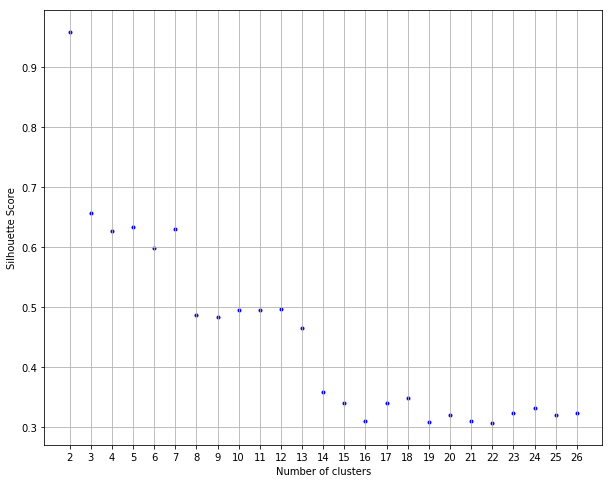

In [712]:
# silhouette scores
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
ax.scatter(k_range, silh_scores, c='blue', marker='.')
ax.set_xticks(k_range)
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette Score')

* PVE plot


([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

In [610]:
# Avg. within-cluster sum of squares 
KM = [KMeans(n_clusters=k).fit(document_topics) for k in k_range] 
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(document_topics, centrds, 'euclidean') for centrds in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k] 
dist = [np.min(D,axis=1) for D in D_k] 
avgWithinSS = [d.sum()/document_topics.shape[0] for d in dist]

In [635]:
len(dist[0])

71441

In [677]:
pdist(document_topics)

MemoryError: Unable to allocate 19.0 GiB for an array with shape (2551872520,) and data type float64

In [684]:
filename = data_dir + "\\" + 'document_topics.npy'
np.save(filename, document_topics)

In [683]:
# from fastdist import fastdist

# fastdist.matrix_pairwise_distance(document_topics, fastdist.euclidean, "euclidean", return_matrix=False)
# # returns an array of shape (10 choose 2, 1)
# # to return a matrix with entry (i, j) as the distance between row i and j
# # set return_matrix=True, in which case this will return a (10, 10) array

In [636]:
# Total with-in sum of square
wcss = [np.sum(d**2) for d in dist] 
tss = np.sum(pdist(document_topics)**2)/document_topics.shape[0] 
bss = tss-wcss

MemoryError: Unable to allocate 19.0 GiB for an array with shape (2551872520,) and data type float64

In [ ]:
# elbow curve - Avg. within-cluster sum of squares 
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.plot(k_range, avgWithinSS, 'b*-') 
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Average within-cluster sum of squares')

In [ ]:
# elbow curve - percentage of variance explained 
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.plot(k_range, bss/tss*100, 'b*-') 
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Percentage of variance explained') 
plt.show()

* Gap statistic plot
    * The gap statistic was developed by Stanford researchers Tibshirani, Walther and Hastie in their 2001 paper. The idea behind their approach was to find a way to standardize the comparison of \log W_k with a null reference distribution of the data, i.e. a distribution with no obvious clustering. Their estimate for the optimal number of clusters K is the value for which \log W_k falls the farthest below this reference curve. This information is contained in the following formula for the gap statistic:

     [Code](https://github.com/teruo41/calc_k_with_gap) 

    [Source](https://datasciencelab.wordpress.com/tag/gap-statistic/)
    
    alternate implementation ipynb ([Source](https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb))

In [713]:
import importlib
import calc_k_with_gap
importlib.reload(calc_k_with_gap)
from calc_k_with_gap import calc_k_with_gap

k, gaps, sks = calc_k_with_gap(document_topics, max_k=27)

calc_k_with_gap() preparing...
calc_k_with_gap() preparing...   Done.
calc_k_with_gap() iteration for i =  0
calc_k_with_gap() iteration for i =  1
calc_k_with_gap() iteration for i =  2
calc_k_with_gap() iteration for i =  3
calc_k_with_gap() iteration for i =  4
calc_k_with_gap() iteration for i =  5
calc_k_with_gap() iteration for i =  6
calc_k_with_gap() iteration for i =  7
calc_k_with_gap() iteration for i =  8
calc_k_with_gap() iteration for i =  9
calc_k_with_gap() iteration for i =  10
calc_k_with_gap() iteration for i =  11
calc_k_with_gap() iteration for i =  12
calc_k_with_gap() iteration for i =  13
calc_k_with_gap() iteration for i =  14
calc_k_with_gap() iteration for i =  15
calc_k_with_gap() iteration for i =  16
calc_k_with_gap() iteration for i =  17
calc_k_with_gap() iteration for i =  18
calc_k_with_gap() iteration for i =  19
calc_k_with_gap() iteration for i =  20
calc_k_with_gap() iteration for i =  21
calc_k_with_gap() iteration for i =  22
calc_k_with_gap() it

In [716]:
len(sks)
k

26

Text(0,0.5,'Gap stat')

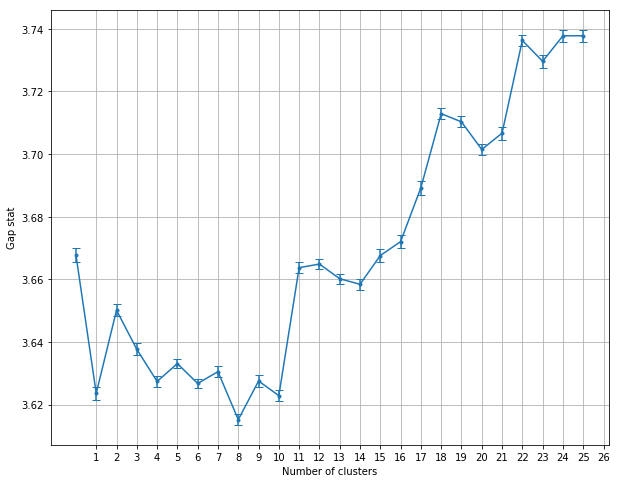

In [753]:
# gap stat
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
#ax.scatter(range(1,k+1), gaps[:-1], c='blue', marker='.')
ax.errorbar(range(k), gaps[:-1],yerr=6*sks[:-1], capsize=4, marker='.')
ax.set_xticks(range(1,k+1))
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Gap stat')

In [799]:
N_CLUSTERS=7 # or 7?

In [ ]:
#k_means_fit = KMeans(n_clusters=N_CLUSTERS,max_iter=300) 
k_means_fit = KMeans(n_clusters=N_CLUSTERS, max_iter=10000, n_init=50, random_state=42)
k_means_fit.fit(document_topics)

In [798]:
from collections import Counter

Counter(k_means_fit.labels_)

Counter({6: 60071,
         2: 8940,
         5: 837,
         0: 999,
         4: 482,
         11: 21,
         9: 4,
         7: 4,
         1: 15,
         10: 46,
         3: 7,
         8: 15})

---
---
---
## Parking lot
  * text analysis with python vid [link](https://www.youtube.com/watch?v=ALGd_frv4rc&feature=youtu.be&ab_channel=J%C3%BCrgenPfeffer)
  * SNA in python vids [link](https://www.youtube.com/playlist?list=PLW5N2mhH4QJqRKrHLWs052mhXyFAsQn-v) 

* pandas find word in str :

In [342]:
# find_word = 'aascsadv'
# df_com[df_com['text'].str.contains(find_word, case=False)]['text'].tolist()

* pandas find token in list :

In [343]:
# find_tkn = '2020comentcomit'  
# df_temp = df_com_pp[df_com_pp.apply(lambda x: find_tkn in x['text'], axis=1)][['text','text_og','link']]

# find_tkn_ind = df_temp.iloc[0, df_temp.columns.get_loc('text')].index(find_tkn)
# print(find_tkn_ind)
# df_temp.iloc[0, df_temp.columns.get_loc('text')][find_tkn_ind-5:find_tkn_ind+5]

# df_temp.iloc[0,df_temp.columns.get_loc('text_og')]

* Pandas positional and label-based indexing :

In [344]:
# df_temp.iloc[0, df_temp.columns.get_loc('text')][40:50]
# dfd.iloc[[0, 2], dfd.columns.get_indexer(['A', 'B'])]
# dfd.loc[dfd.index[[0, 2]], 'A']

* Display df unlimited

In [345]:
# with pd.option_context('display.max_colwidth', None):
#     #pd.set_option('display.max_columns', None)
#     display(df_temp)

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

SVD -> NMF

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Construct a face with linear combinations of features
Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

In [589]:
# from sklearn.metrics.pairwise import cosine_similarity
# import math

# def nCr(n,r):
#     f = math.factorial
#     return f(n) // f(r) // f(n-r)

# def mean_pairwise_cosine_sim(topic_terms, num_topics):
#     sim_matrix = cosine_similarity(topic_terms) # Construct a topic similarity matrix
#     return np.mean(sim_matrix) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 
#     #return np.tril(sim_matrix, -1).sum()/nCr(num_topics, 2) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 

In [785]:
# import dill
# filename = data_dir + "\\" + 'notebook_session_02_02_1251.db'
# dill.dump_session(filename)
# #dill.load_session('notebook_session.db')